# Gaussian Process - An illustration

This notebook is designed to introduce and illustrate Gaussian processes in a practical way, presenting the concepts introduced in the theory session. We have covered key aspects of Gaussian process regression: the covariance function (a.k.a. *kernels*), sampling a Gaussian process and the regression model. The notebook will introduce the Python library `GPy` which handles the kernels, regression and optimisation of hyperparameter, allowing us to easily access the results we want.

## Getting started

First, we need to setup our notebook with the libraries we are going to use. We will use `numpy` for maths functionality, `pyplot` for plotting and `GPy` for Gaussian processes. There are many other options for GPs, like the famous `GPTorch`, but `GPy` will suffice for this illustrative examples.

In [2]:
# Support for maths
import numpy as np
# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

The documentation for `GPy` is available at [gpy.readthedocs.io](http://gpy.readthedocs.io/en/deploy/). We will be using GPy to define our kernels, and regression. Note that `GPy` also contains plotting utilities, but we will not use these in this lab.

## 1. Covariance functions, aka kernels

We will define a covariance function, from hereon referred to as a kernel, using `GPy`. The most commonly used kernel in machine learning is the Gaussian-form radial basis function (RBF) kernel. It is also commonly referred to as the exponentiated quadratic or squared exponential kernel &ndash; all are equivalent.

The definition of the (1-dimensional) RBF kernel has a Gaussian-form, defined as:

$$
    \kappa_\mathrm{rbf}(x,x') = \sigma^2\exp\left(-\frac{(x-x')^2}{2\mathscr{l}^2}\right)
$$

It has two parameters, described as the variance, $\sigma^2$ and the lengthscale $\mathscr{l}$.

In GPy, we define our kernels using the input dimension as the first argument, in the simplest case `input_dim=1` for 1-dimensional regression. We can also explicitly define the parameters, but for now we will use the default values:

In [3]:
# Create a 1-D RBF kernel with default parameters
k = GPy.kern.RBF(1)
# Preview the kernel's parameters
k

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1.0,+ve,


We can see from the above table that our kernel has two parameters, `variance` and `lengthscale`, both with value `1.0`. There is also information on the constraints and priors on each parameter, but we will look at this later.

### Visualising the kernel

We can visualise our kernel in a few different ways. We can plot the _shape_ of the kernel by plotting $k(x,0)$ over some sample space $x$ which, looking at the equation above, clearly has a Gaussian shape. This describes the covariance between each sample location and $0$.

Alternatively, we can construct a full covariance matrix, $\mathbf{K}_{xx} \triangleq k(x,x')$ with samples $x = x'$.

Alternatively, we can construct a **full covariance matrix**, denoted as $\mathbf{K}_{xx} \triangleq k(x,x')$, it indicates that the matrix $\mathbf{K}_{xx}$ is created by applying a kernel function $k$ to every possible pair of input samples, i.e. when we talk about the matrix $\mathbf{K}_{xx}$ for a set of points $\{x_1, x_2, x_3\}$, we are looking at a square structure where each element is the result of the kernel function $k(x_i, x_j)$:

$$
\mathbf{K}_{xx} =
\begin{bmatrix}
k(x_1, x_1) & k(x_1, x_2) & k(x_1, x_3) \\
k(x_2, x_1) & k(x_2, x_2) & k(x_2, x_3) \\
k(x_3, x_1) & k(x_3, x_2) & k(x_3, x_3)
\end{bmatrix}
$$

The resulting **GP prior** is modeled as a **multivariate normal distribution** over the space of samples $x$:

$$\mathcal{N}(\mathbf{0}, \mathbf{K}_{xx})$$

It should be evident then that the elements of the matrix represents the covariance between respective points in $x$ and $x'$, and that it is exactly $\sigma^2$ in the diagonal.<

We can show this using `pyplot` to plot the vector $k(x,0)$ and the matrix $k(x,x')$ using `k.K(`$\cdot$ `,` $\cdot$`)`:

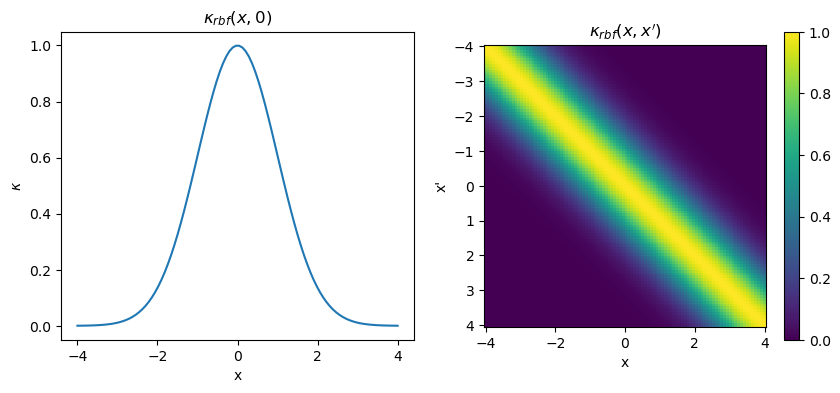

In [4]:
# Our sample space: 100 samples in the interval [-4,4]
X = np.linspace(-4.,4.,100)[:, None] # we need [:, None] to reshape X into a column vector for use in GPy

# Set up the plotting environment
plt.figure(figsize=(10,4))

# ==== k(x,0)

plt.subplot(121) # left plot

# First, sample kernel at x' = 0
K = k.K(X, np.array([[0.]])) # k(x,0)

# Plot covariance vector
plt.plot(X,K)

# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.title("$\kappa_{rbf}(x,0)$")

# ==== k(x,x')

plt.subplot(122) # right plot

# The kernel takes two inputs, and outputs the covariance between each respective point in the two inputs
K = k.K(X,X)

# Plot the covariance of the sample space
plt.pcolor(X.T, X, K)

# Format and annotate plot
plt.gca().invert_yaxis(), plt.gca().axis("image")
plt.xlabel("x"), plt.ylabel("x'"), plt.colorbar()
plt.title("$\kappa_{rbf}(x,x')$");

---

## 2. Types of covariance function

There are many different covariance functions already implemented in `GPy`. Aside from the `RBF` kernel, there are others such as the following:
- `Exponential`
- `Matern32`
- `Matern52`
- `Brownian`
- `Bias`
- `Linear`
- `StdPeriodic`
- `Cosine`
- `PeriodicMatern32`

This is nothing but a simple example, feel free to experiment with whichever kernel may suit your task

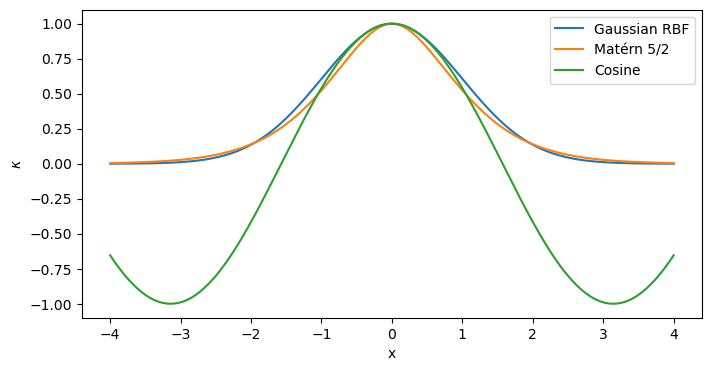

In [5]:
# Our sample space : 100 samples in the interval [-4,4]
X = np.linspace(-4.,4.,250)[:, None]

# RBF kernel
k_R = GPy.kern.RBF(1)
C_R = k_R.K(X, np.array([[0.]]))

# Matern 5/2
k_M = GPy.kern.Matern52(1)
C_M = k_M.K(X, np.array([[0.]]))

# Cosine
k_C = GPy.kern.Cosine(1)
C_C = k_C.K(X, np.array([[0.]]))

plt.figure(figsize=(8,4))
plt.plot(X, C_R, X, C_M, X, C_C);
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.legend(labels=["Gaussian RBF", "Matérn 5/2", "Cosine"]);

## 3. Sampling from a GP prior

A Gaussian process provides a prior over some infinite-dimensional function, defined by a mean function and covariance function

$$ f(x) \sim \mathcal{GP}(m(x), k(x,x'))$$

When we sample from the covariance function, $k$, to create a matrix over some sample space, we are creating a matrix of values that describe the covariance between sample points. Since it is not possible to sample every single point in an infinite dimensional function, we have to sample a finite subset of the input domain. Let $\mathbf{X}$ denote some sample inputs, and $\mathbf{K}$ the covariance matrix, with elements $K_{ij} = k(\mathbf{X}_i,\mathbf{X}_j)$, then we can describe the prior over $f(\mathbf{X})$ as a (finite-dimensional) normal distribution with covariance $\mathbf{K}$. As such, we can easily create samples of $f$ which, for a good choice of $\mathbf{X}$, are representative of the true function.

We can also sample from the kernel prior by creating a covariance matrix over a sample space and sampling from a zero-mean multivariate normal distribution with covariance $\mathbf{K}$. Below are examples of different kernels with different parameters, including composite kernels.

The following plots demonstrate samples from a Gaussian process prior and the corresponding covariance matrix


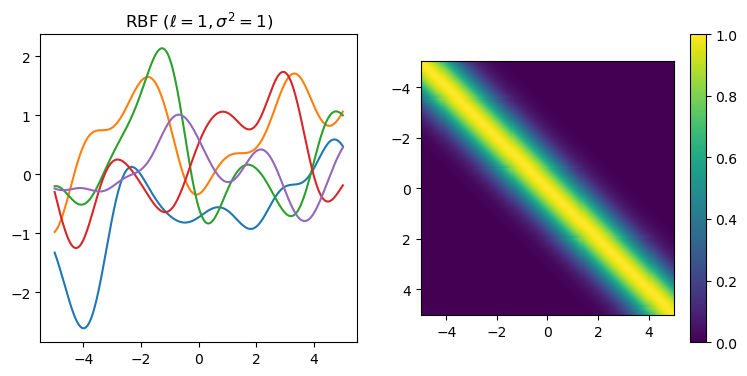

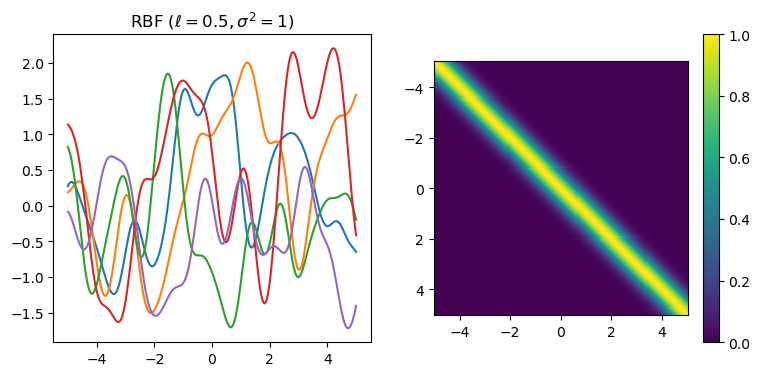

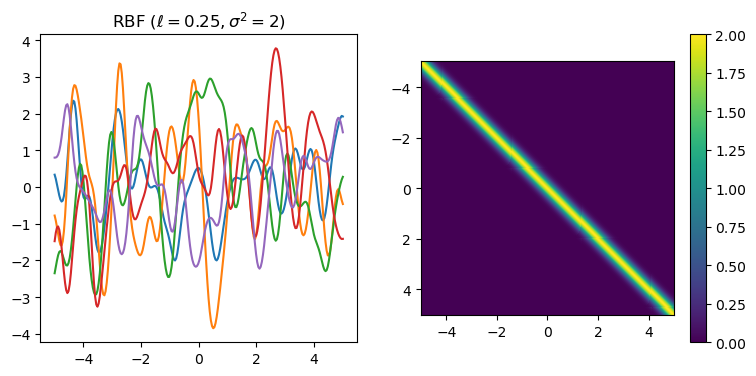

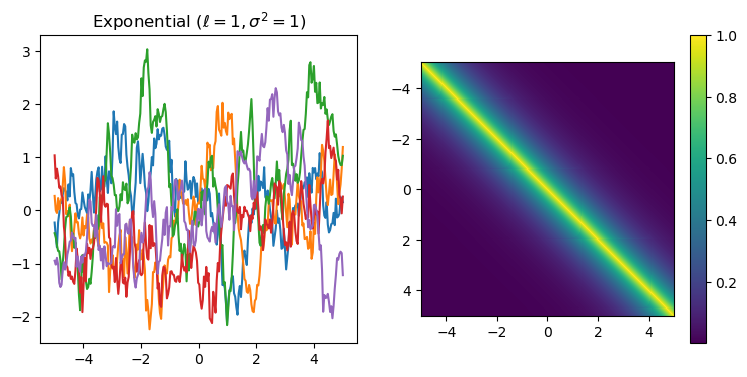

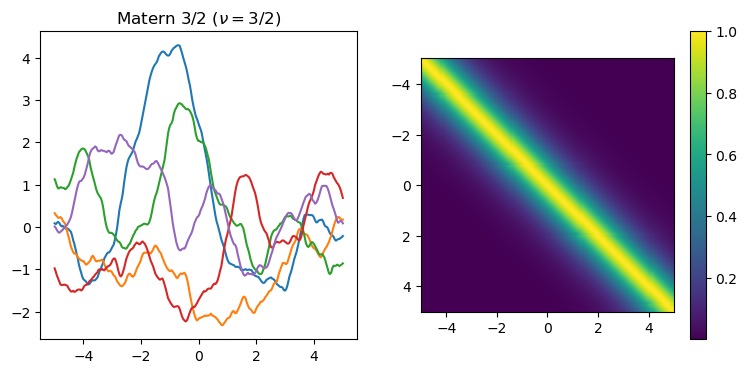

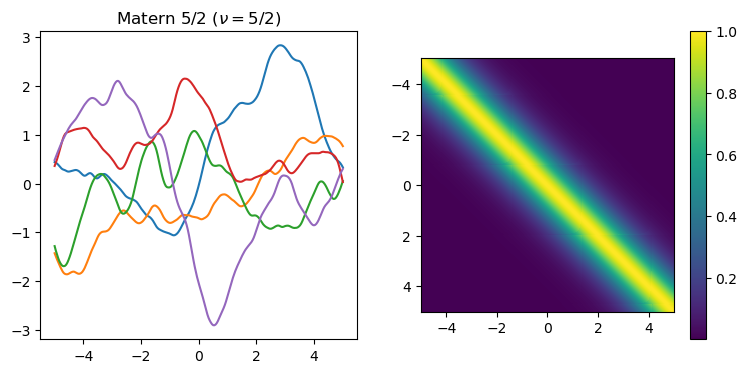

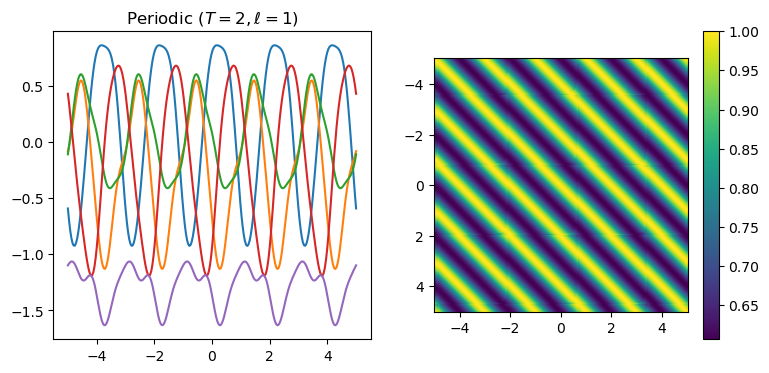

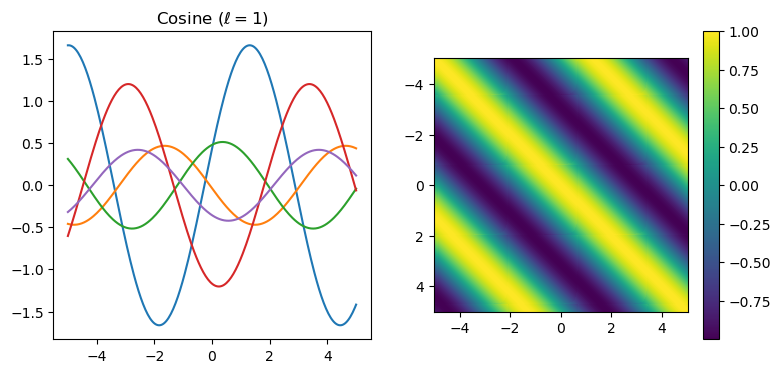

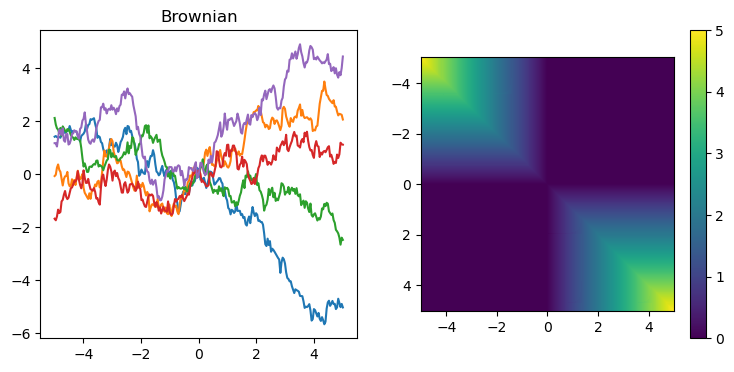

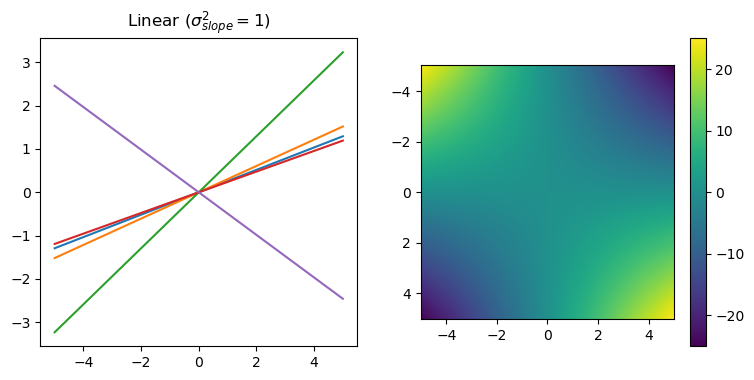

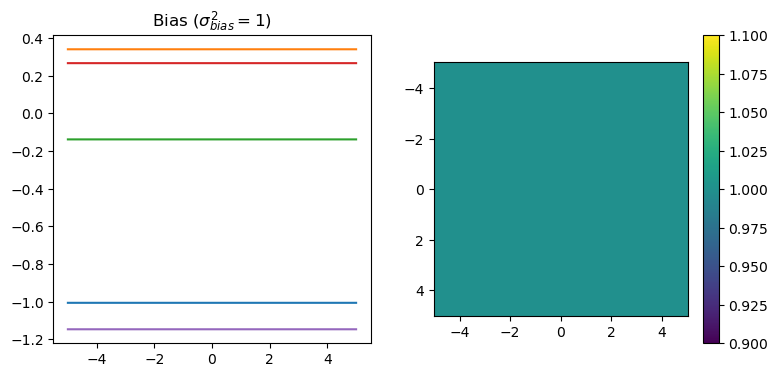

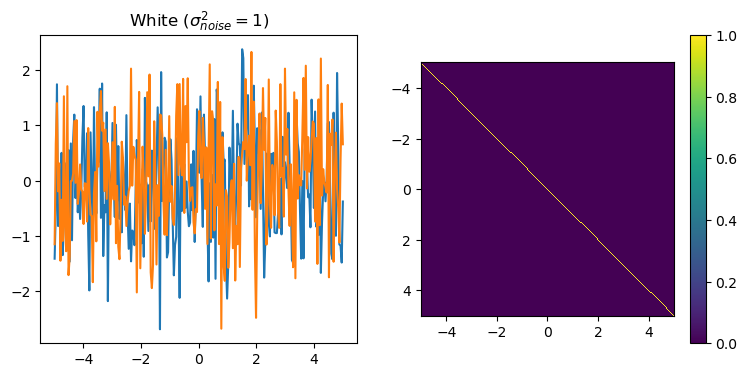

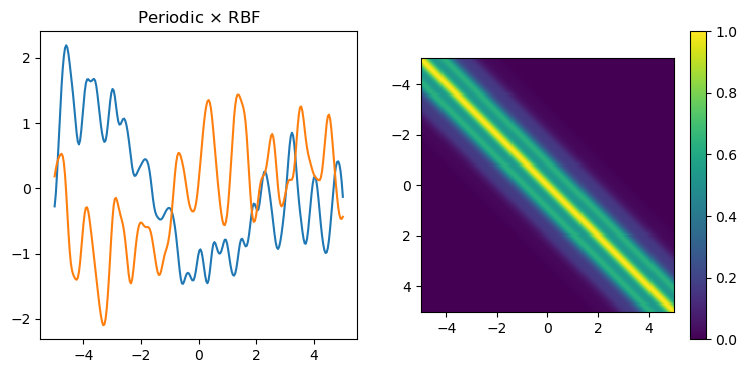

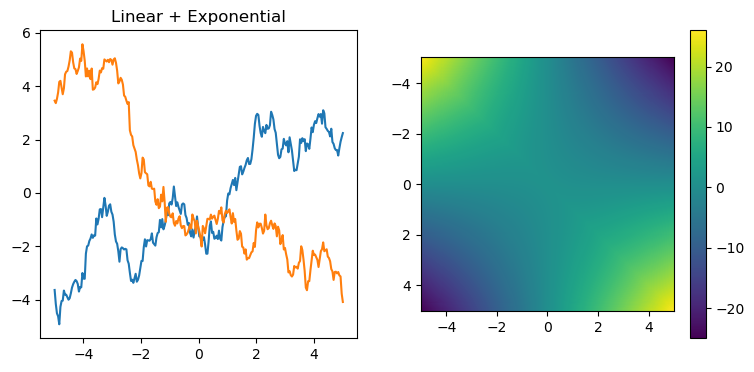

In [6]:
ks = [ # List of example kernels
    GPy.kern.RBF(1, lengthscale=1.),
    GPy.kern.RBF(1, lengthscale=0.5),
    GPy.kern.RBF(1, lengthscale=0.25, variance=2.),
    GPy.kern.Exponential(1),
    GPy.kern.Matern32(1),
    GPy.kern.Matern52(1),
    GPy.kern.StdPeriodic(1, period=2.),
    GPy.kern.Cosine(1),
    GPy.kern.Brownian(1),
    GPy.kern.Linear(1),
    GPy.kern.Bias(1),
    GPy.kern.White(1),
    GPy.kern.StdPeriodic(1)*GPy.kern.RBF(1),
    GPy.kern.Linear(1) + GPy.kern.Exponential(1)
]
# The name of our kernels (for the legend)
kernel_name = [
    r"RBF ($\ell=1, \sigma^2=1$)",
    r"RBF ($\ell=0.5, \sigma^2=1$)",
    r"RBF ($\ell=0.25, \sigma^2=2$)",
    r"Exponential ($\ell=1, \sigma^2=1$)",
    r"Matern 3/2 ($\nu=3/2$)",
    r"Matern 5/2 ($\nu=5/2$)",
    r"Periodic ($T=2, \ell=1$)",
    r"Cosine ($\ell=1$)",
    r"Brownian",
    r"Linear ($\sigma^2_{slope}=1$)",
    r"Bias ($\sigma^2_{bias}=1$)",
    r"White ($\sigma^2_{noise}=1$)",
    r"Periodic $\times$ RBF",
    r"Linear + Exponential"
]
# Our sample space
X = np.linspace(-5., 5., 250)[:, None]

print("The following plots demonstrate samples from a Gaussian process prior and the corresponding covariance matrix")

# Loop through our kernels
for i,k in enumerate(ks):
    # The mean function is set to 0
    mu = np.zeros((250)) # we have 250 sample inputs
    # Get the covariance matrix
    if i is not 11:
        C  = k.K(X,X)
    else: # We have to sample White noise kernel differently
        C = k.K(X)

    # Sample 5 times from a multivariate Gaussian distribution with mean 0 and covariance k(X,X)
    Z  = np.random.multivariate_normal(mu, C, 5)

    # Setup figure environment
    plt.figure(figsize=(9, 4))

    # Show samples on left hand side
    plt.subplot(121)
    for j in range(5 if i < 11 else 2): # Loop through samples
        plt.plot(X[:],Z[j,:])
        plt.title(kernel_name[i])

    # Visualise covariance matrix on right hand side
    plt.subplot(122)
    plt.pcolor(X.T, X, C)
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()

## 4. Kernel Effects: Encoding Prior Knowledge

The choice of the covariance function (kernel) and its hyperparameters is the primary way we encode our prior assumptions about the function we are trying to model. 
* **Variance ($\sigma^2$)**: Determines the average distance of the function away from its mean.
* **Lengthscale ($l$)**: Determines the "wiggliness" of the function. A short lengthscale means the function changes rapidly, while a long lengthscale means it changes slowly.

We can try and visualize how the lengthscale of an RBF kernel affects the functions sampled from the GP prior as an example of these effects.

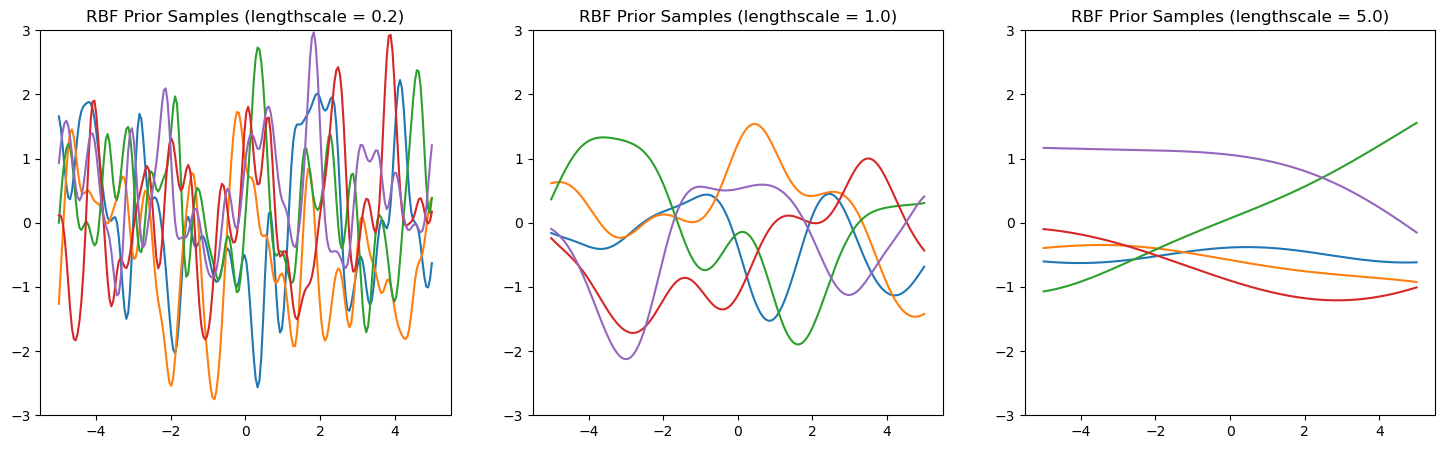

In [7]:
# Define sample space
X_sample = np.linspace(-5, 5, 200)[:, None]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
lengthscales = [0.2, 1.0, 5.0]

for ax, l in zip(axes, lengthscales):
    k_rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=l)
    mu = np.zeros(len(X_sample))
    C = k_rbf.K(X_sample, X_sample)
    
    # Sample 5 functions from the prior
    Z = np.random.multivariate_normal(mu, C, 5)
    for z in Z:
        ax.plot(X_sample, z)
    ax.set_title(f'RBF Prior Samples (lengthscale = {l})')
    ax.set_ylim(-3, 3)

plt.show()

## 5. Gaussian Process Regression

We will now use our Gaussian process prior with some observed data to form a GP regression model. Suppose we have a data model for which we only have noisy observations, $y = f(x) + \epsilon$ at some small number of sample locations, $\mathbf{X}$. Here, we set up an example function

$$
    f(x) = -\cos(2\pi x) + \frac{1}{2}\sin(6\pi x)
$$
$$
    \mathbf{y} = f(\mathbf{X}) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.01)
$$

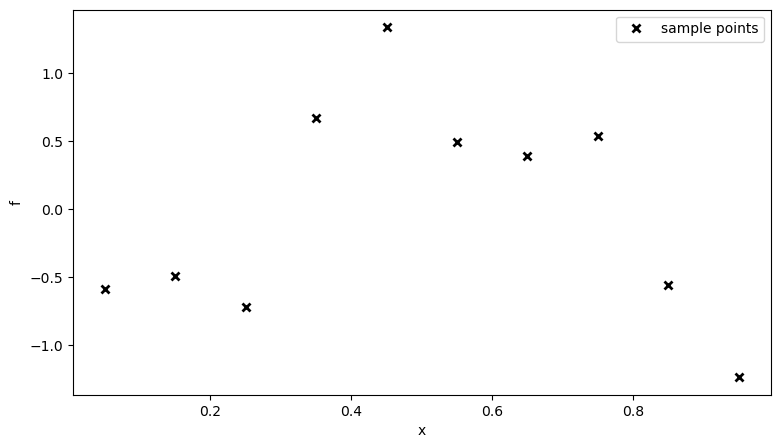

In [8]:
# lambda function, call f(x) to generate data
f = lambda x: -np.cos(2*np.pi*x) + 0.5*np.sin(6*np.pi*x)

# 10 equally spaced sample locations
X = np.linspace(0.05, 0.95, 10)[:,None]

# y = f(X) + epsilon
Y = f(X) + np.random.normal(0., 0.1, (10,1)) # note that np.random.normal takes mean and s.d. (not variance), 0.1^2 = 0.01

# Setup our figure environment
plt.figure(figsize=(9, 5))

# Plot observations
plt.plot(X, Y, "kx", mew=2)

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

We will fit a Gaussian Process using the exact equations. A Gaussian Process regression model using a Gaussian RBF covariance function can be defined first by setting up the kernel:

In [9]:
k = GPy.kern.RBF(1, variance=1., lengthscale=0.1, name="rbf")

And then combining it with the data to form a Gaussian process regression model, with $\mathbf{X}^*$ representing _any_ new inputs (imagine $\mathbf{f}^*$ approximates $f(\mathbf{X}^*)$):

$$
\left.\mathbf{f}^*\,\right|\,\mathbf{X}^*,\mathbf{X},\mathbf{y} \sim \mathcal{N}\left(\mathbf{m}, \mathbf{C}\right),
$$

where $\mathbf{m} = \mathbf{K}_{*x}(\mathbf{K}_{xx} + \sigma^2\mathbf{I})^{-1}\mathbf{y}$ and $\mathbf{C} = \mathbf{K}_{**} -  \mathbf{K}_{*x}(\mathbf{K}_{xx} + \sigma^2\mathbf{I})^{-1}\mathbf{K}_{*x}^\text{T}$ and covariance matrices are defined by evaluations of the kernel functions: 

$$
\mathbf{K}_{xx} = k(\mathbf{X}, \mathbf{X}); \quad \mathbf{K}_{*x} = k(\mathbf{X}^*, \mathbf{X}); \quad \mathbf{K}_{**} = k(\mathbf{X}^*,\mathbf{X}^*)
$$

In [10]:
# New test points to sample function from
Xnew = np.linspace(-0.05, 1.05, 100)[:, None]

# Covariance between training sample points (+ Gaussian noise)
Kxx = k.K(X,X) + 1 * np.eye(10)

# Covariance between training and test points
Ksx = k.K(Xnew, X)

# Covariance between test points
Kss = k.K(Xnew,Xnew)

# The mean of the GP fit (note that @ is matrix multiplcation: A @ B is equivalent to np.matmul(A,B))
mean = Ksx @ np.linalg.inv(Kxx) @ Y
# The covariance matrix of the GP fit
Cov = Kss - Ksx @ np.linalg.inv(Kxx) @ Ksx.T

Here we define a quick plotting utility function for our GP fits. There are a number of plotting options available in GPy, but we will use the below method, which plots the mean and 95% confidence fit of a GP for a given input $\mathbf{X}^*$. Optionally, we will allow it to plot the initial training points.

In [11]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])

    plt.xlabel("x"), plt.ylabel("f")

    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])

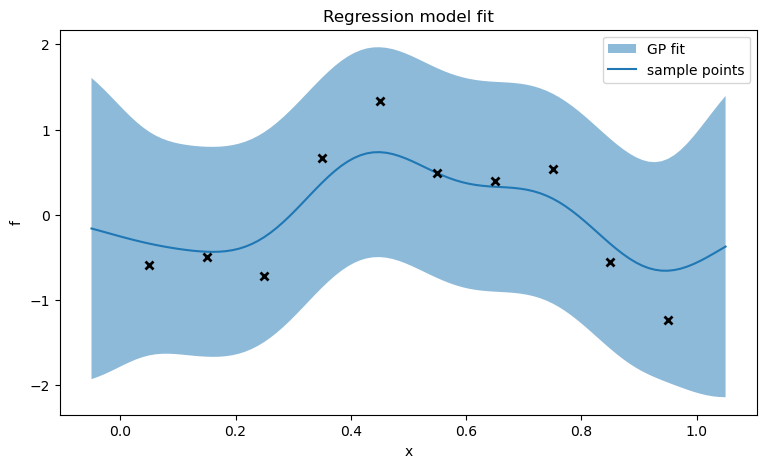

In [12]:
# Plot the results of the fit
plt.figure(figsize=(9, 5))

# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("Regression model fit");

We can also save effort and time by to do Gaussian process regression using `GPy`, by creating a GP regression model with sample points $(\mathbf{X}, \mathbf{Y})$ and the Gaussian RBF kernel:

In [13]:
m = GPy.models.GPRegression(X, Y, k)
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,0.1,+ve,
Gaussian_noise.variance,1.0,+ve,


We can use GPy's regression and prediction tools, which _should_ give the same result as our basic implementation:

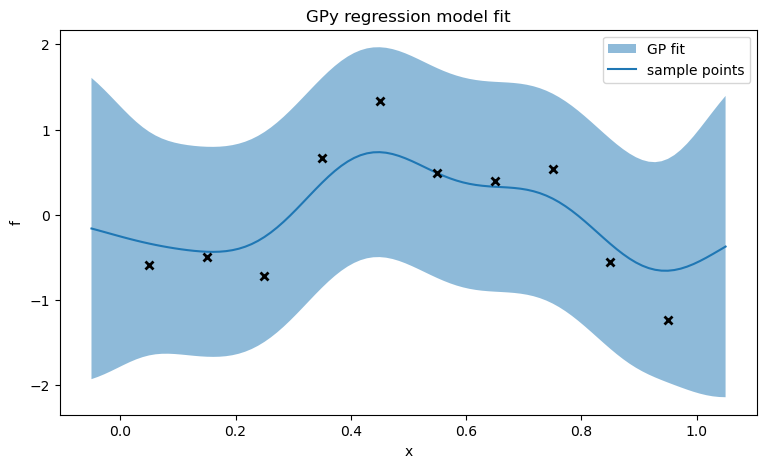

In [14]:
# Use GPy model to calculate the mean and covariance of the fit at Xnew
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

plt.figure(figsize=(9, 5))

# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("GPy regression model fit");

It can be clearly seen that this *is* the same fit as our above model. However, using GPy gives flexibility and ease of use for extending the capabilities of the fitting, including use of different kernels, optimising parameters and solving more complicated problems, including classification. We also don't need to write explicit equations and manually creating covariances matrices.

The parameters of the model can be editted much like those of the kernel. Note that changing the original kernel `k` will also affect the model parameters due to how Python connects objects, but this is not a reliable way of setting the parameters, so you should adjust the kernel parameters via the model `m` as described*

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,0.1,+ve,
Gaussian_noise.variance,0.01,+ve,


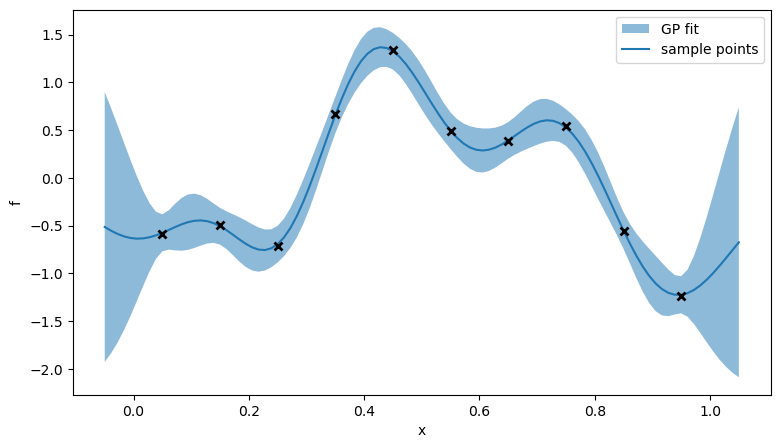

In [15]:
m.Gaussian_noise = 0.01
m.rbf.lengthscale = 0.1

mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

plt.figure(figsize=(9, 5))
# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))

# Preview the regression model
display(m)

We can try and sample from the GP posterior to see how they look. We will sample from the full covariance matrix using `full_cov=True`.

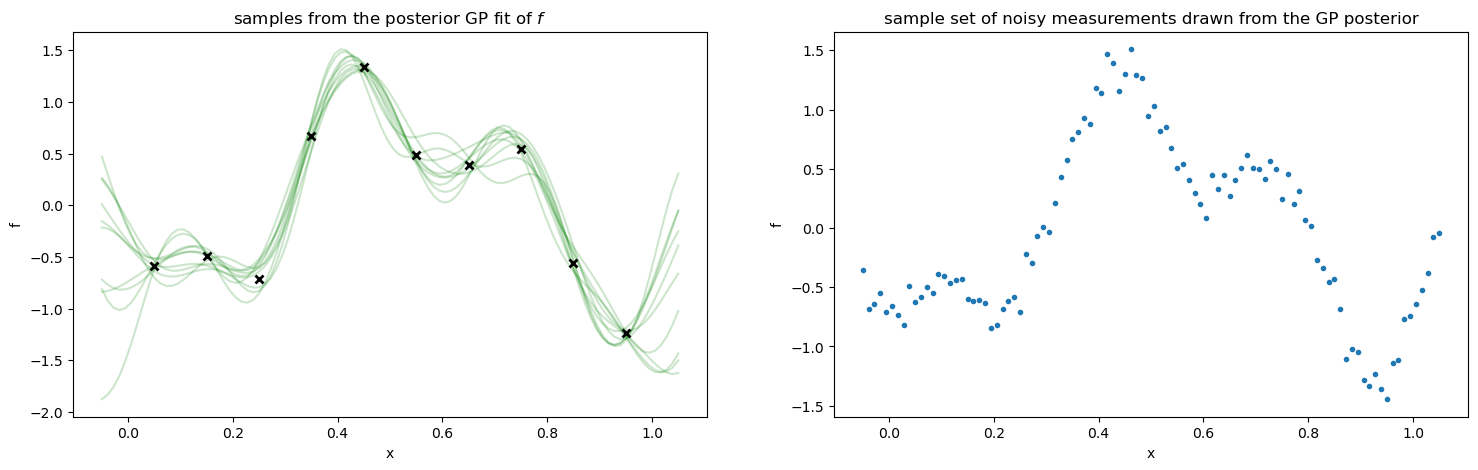

In [16]:
plt.figure(figsize=(18, 5))

mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

Z  = np.random.multivariate_normal(mean[:,0], Cov, 10)
plt.subplot(121)
for z in Z:
    plt.plot(Xnew, z, "g-", alpha=0.2)
plt.plot(X, Y, "kx", mew=2)
plt.xlabel("x"), plt.ylabel("f"), plt.title("samples from the posterior GP fit of $f$")

mean, Cov = m.predict(Xnew, full_cov=True)
z  = np.random.multivariate_normal(mean[:,0], Cov)
plt.subplot(122)
plt.plot(Xnew, z, ".")
plt.xlabel("x"), plt.ylabel("f"), plt.title("sample set of noisy measurements drawn from the GP posterior");

---

## 6. Kernel Hyperparameters Optimization

The values of kernel parameters can be estimated by maximising the likelihood of the observations. This is useful to optimise our estimate of the underlying function, without eye-balling parameters to get a good fit. In `GPy`, the `model` objects such as `GPRegression`, have parameter optimisation functionality. We can call this as following:

In [17]:
m.optimize()
m

GP_regression.,value,constraints,priors
rbf.variance,0.7038213166850162,+ve,
rbf.lengthscale,0.10836094336351673,+ve,
Gaussian_noise.variance,6.231270548241242e-09,+ve,


We can see the selected parameters in the model table above. The regression fit with the optimised parameters can be plotted:

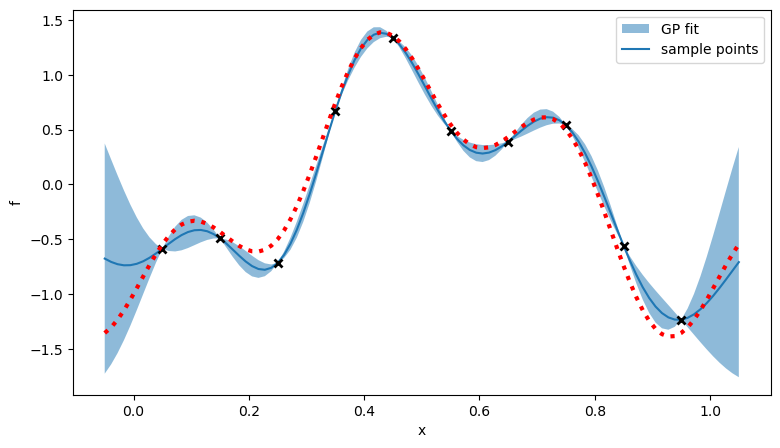

In [18]:
# Get mean and covariance of optimised GP
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

# Setup the figure environment
plt.figure(figsize=(9, 5))

# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.plot(Xnew, f(Xnew), "r:", lw=3)

### Parameter constraints

We can see in the above model that the regression model is fit to the data, as the optimiser has minimised the noise effect in the model, `Gaussian_noise.variance`$ = 4.804\times10^{-8}$. If we *know*, or can reasonably approximate, the variance of the observation noise $\epsilon$, we can fix this parameter for the optimiser, using `fix`, which in the case of the above is $0.01$. We can also limit the values that the parameters take by adding constraints. For example, the variance and lengthscale can only be positive, so calling `constrain_positive`, we can enforce this (note that this is the default constraint for GP regression anyway).

In [19]:
# Constrain the regression parameters to be positive only
m.constrain_positive()

# Fix the Gaussian noise variance at 0.01
m.Gaussian_noise.variance = 0.01 # (Reset the parameter first)
m.Gaussian_noise.variance.fix()

# Reoptimise
m.optimize()
m

reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.675419276314153,+ve,
rbf.lengthscale,0.10804093577620265,+ve,
Gaussian_noise.variance,0.01,fixed +ve,


We can see our constraints in the corresponding column in the above table, where "`+ve`" means we are constrained to positive values, and `fixed` means the optimiser will not try and optimise this parameter. We can see here that the variance of the noise in the model is unchanged by the optimiser. Looking at the resulting plot, we can see that we have a much more reasonable confidence in our estimate, and that the true function is hard to distinguish from samples drawn from our fit, indicating that we have reasonable approximation of the true function given noisy observations.

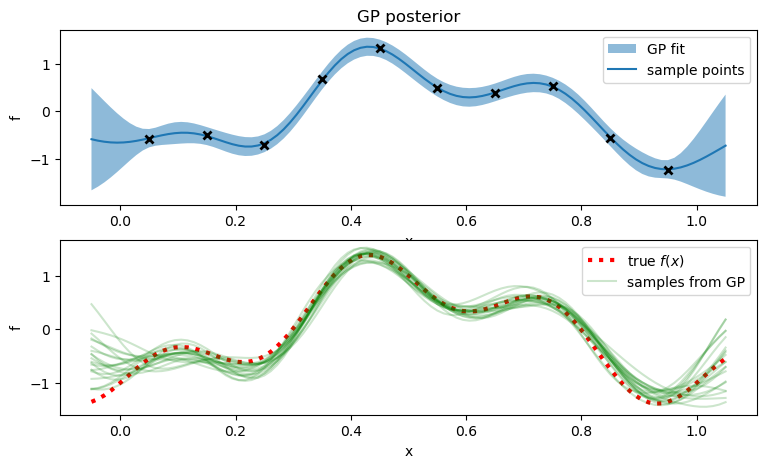

In [20]:
# Get mean and covariance of optimised GP
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

# Setup our figure environment
plt.figure(figsize=(9, 5))

# The top plot shows our mean regression fit and 95% confidence intervals
plt.subplot(211)
# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("GP posterior")
plt.subplot(212)

plt.plot(Xnew, f(Xnew),"r:", lw=3)

Z  = np.random.multivariate_normal(mean[:,0], Cov, 20)
for z in Z:
    plt.plot(Xnew,z, "g-", alpha=0.2)

plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["true $f(x)$", "samples from GP"]);

## 7. Scalability and Sparse Gaussian Processes

Standard Gaussian Process regression requires the inversion of the covariance matrix $\mathbf{K}_{xx}$, which scales as $\mathcal{O}(N^3)$ in computational complexity and $\mathcal{O}(N^2)$ in memory, where $N$ is the number of training points. This becomes intractable for datasets larger than a few thousand points.

**Sparse GPs** solve this by introducing $M$ **inducing points** ($M \ll N$). These points act as a summary of the dataset, reducing the complexity to $\mathcal{O}(NM^2)$. In `GPy`, the inducing points are treated as variational parameters and optimized alongside the kernel hyperparameters using Variational Inference.

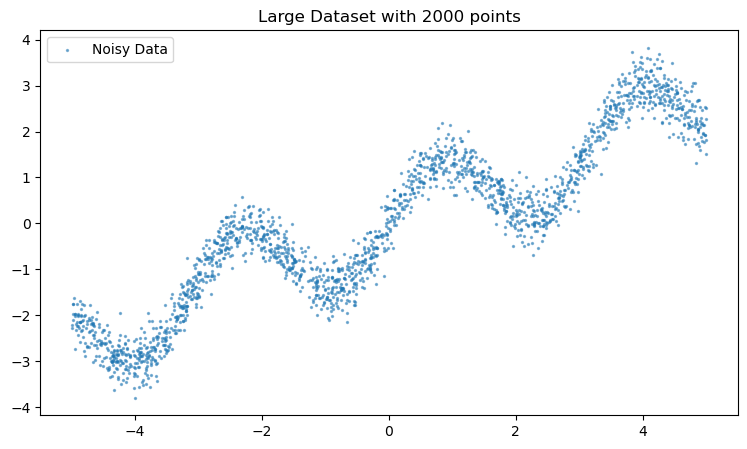

In [21]:
# Generate a larger dataset (e.g., N = 2000)
N_large = 2000
X_large = np.random.uniform(-5, 5, (N_large, 1))
# True function: sine wave with increasing amplitude + noise
Y_large = np.sin(2 * X_large) + 0.5 * X_large + np.random.randn(N_large, 1) * 0.3

plt.figure(figsize=(9, 5))
plt.scatter(X_large, Y_large, s=2, alpha=0.5, label='Noisy Data')
plt.title(f"Large Dataset with {N_large} points")
plt.legend()
plt.show()

In [22]:
# We choose M = 10 inducing points, initialized randomly within the data range
M = 10
Z = np.random.uniform(-5, 5, (M, 1))

# Define the Sparse GP Regression model
sparse_model = GPy.models.SparseGPRegression(X_large, Y_large, Z=Z)

# Optimize hyperparameters and inducing point locations
sparse_model.optimize('bfgs', messages=True)

# Display the optimized model parameters
display(sparse_model)

sparse_gp.,value,constraints,priors
inducing inputs,"(10, 1)",,
rbf.variance,119.1520431908349,+ve,
rbf.lengthscale,1.9377860036020613,+ve,
Gaussian_noise.variance,0.09618941512685164,+ve,


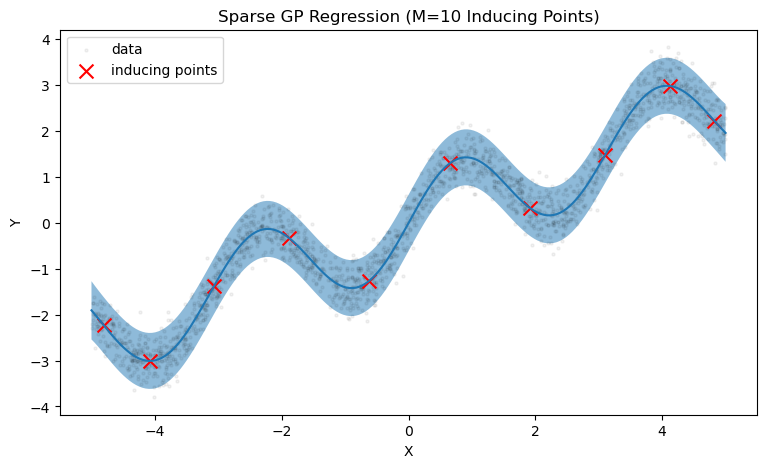

In [23]:
# Make predictions on a grid of inputs
Xnew = np.linspace(-5, 5, 200)[:, None]
mean, Cov = sparse_model.predict(Xnew, full_cov=True)

# Plot the predictive posterior
plt.figure(figsize=(9, 5))

# first draw the GP fit without the training points so we can customize them
plot_gp(Xnew, mean, Cov, training_points=None)

# overlay original data as small, semi-transparent dots
plt.scatter(X_large, Y_large, s=5, alpha=0.05, c='k', label='data')

# Overlay inducing points (at their predictive mean)
Z_opt = sparse_model.Z.values if hasattr(sparse_model.Z, "values") else sparse_model.Z
mean_Z, _ = sparse_model.predict(Z_opt)
plt.scatter(Z_opt, mean_Z, c="r", marker="x", label="inducing points", s=100)

# finalize legend and labels
plt.legend()
plt.title(f"Sparse GP Regression (M={M} Inducing Points)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()